# Process signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from atmospheric_lidar import licelv2
import glob
import os
#from atmospheric_lidar.licel import LicelLidarMeasurement
from lifa.licel import LicelLidarMeasurement

## load measurement files

In [2]:
# Measurements directories to compare
directories = [r"D:\Local - OURO NOVA\Medidas CEPEMA\20241204-Alex e Jairo\Topo chama p-23mm",
          r"D:\Local - OURO NOVA\Medidas CEPEMA\20241204-Alex e Jairo\Acima da chama p=23 mm",
          r"D:\Local - OURO NOVA\Medidas CEPEMA\20241204-Alex e Jairo\Em baixo chama p 23",
          r"D:\Local - OURO NOVA\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm",
          r"D:\Local - OURO NOVA\Medidas CEPEMA\20241204-Alex e Jairo\Meio chama p=23mm bom pra caralho",
          r"D:\Local - OURO NOVA\Medidas CEPEMA\20241204-Alex e Jairo\Na chama topo 4094 shots"
          ]

# Licel Channels of interest
licel_channels_names = ['00355.o_an', '00395.s_an', '00353.o_an', '00371.o_an', '00395.p_an', '00460.o_an', '00532.o_an', '00530.o_an']

# Licel file wildcard (usually files starts with a, so a*.* is a good wildcard)
file_wildcard = 'a*.*'

# Get files list in each directory
measurement_files = {}
for sub_dir in directories:
    measurement_files[os.path.basename(sub_dir)] = glob.glob(os.path.join(sub_dir,file_wildcard))

# Read files
measurements = {}
for name, files in measurement_files.items():
    measurements[name] = LicelLidarMeasurement(files)

# Subset by channels
measurements_full = {}
for name, data in measurements.items():
    measurements_full[name] = data.subset_by_channels(licel_channels_names)

# Subset by bins
bin_min = 50
bin_max = 300
measurements_subset = {}
for name, data in measurements_full.items():
    measurements_subset[name] = measurements_full[name].subset_by_bins(bin_min,bin_max)

# Average measurements on a channel 
measurements_average = {}
for name, data in measurements_subset.items():
    signal = []
    for channel_name, channel in measurements_subset[name].channels.items():
        signal.append([channel.z, channel.average_profile()])
        distance = channel.z
    signal = np.array(signal)
    measurements_average[name] = signal

## Plot raw signals

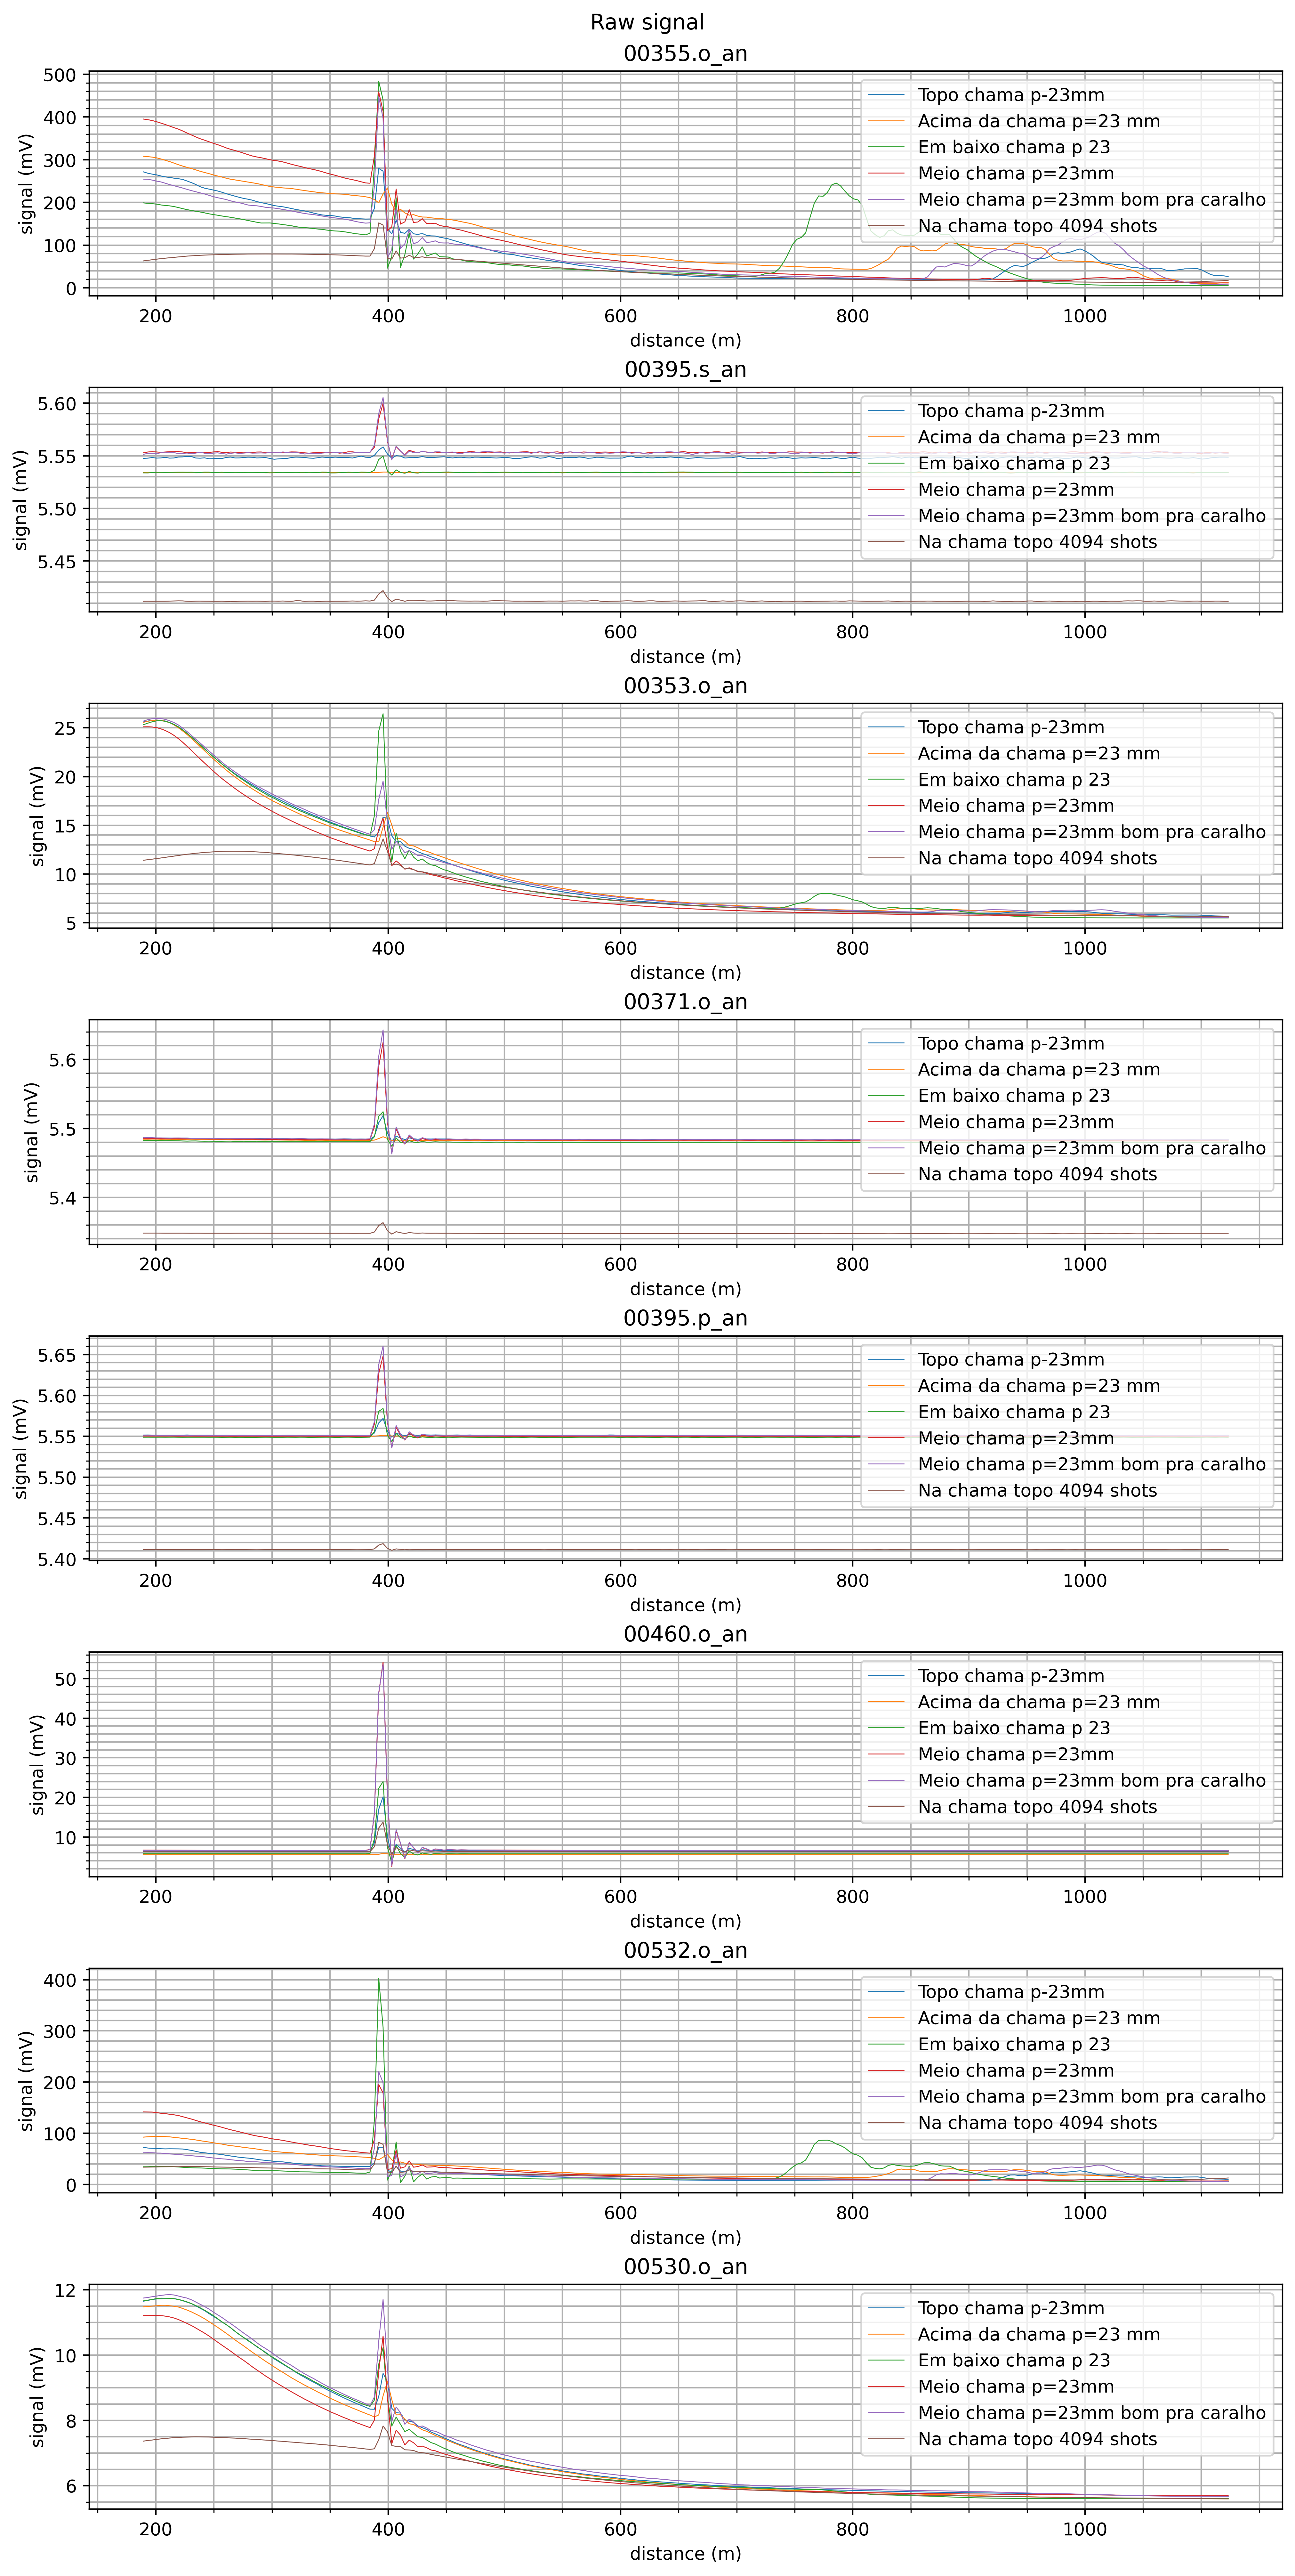

In [3]:
number_traces = len(licel_channels_names)
fig, ax = plt.subplots(nrows=number_traces, figsize=(10,20), dpi=400, layout='constrained')
fig.suptitle('Raw signal')
for name, data in measurements_average.items():
    for i,trace in enumerate(measurements_average[name]):
        ax[i].plot(trace[0], trace[1], label=name, linewidth=0.5)
        ax[i].set_title(licel_channels_names[i])
        ax[i].grid(True, 'both')
        ax[i].minorticks_on()
        ax[i].set_xlabel('distance (m)')
        ax[i].set_ylabel('signal (mV)')
        ax[i].legend(loc = 'upper right')

fig.savefig('raw_signals_lidar.png')

## Processing signals

In [4]:
#channels signals
c355 = '00355.o_an'
c395s = '00395.s_an'
c353 = '00353.o_an'
c371 = '00371.o_an'
c395p = '00395.p_an'
c460 = '00460.o_an'
c532 = '00532.o_an'
c530 = '00530.o_an'

# measurements
c_ch4 = 0
c_co2 = 1
c_n2o2_355 = 2
c_n2o2_532 = 3
c_fluo_ch4 = 4
c_fluo_460 = 5

calibrated_channel_names = ['Raman CH4', 'Raman CO2', 'Raman N2O2 355 nm', 'Raman N2O2 532 nm', 'Fluorescence CH4', 'Fluorecence 460 nm']

licel_channels_names = ['00355.o_an', '00395.s_an', '00353.o_an', '00371.o_an', '00395.p_an', '00460.o_an', '00532.o_an', '00530.o_an']

In [5]:
# move data to matrix
meas = measurements_full['Acima da chama p=23 mm']
signal = []
for channel_name, channel in meas.channels.items():
    signal.append(channel.average_profile())
    distance = channel.z
signal = np.array(signal)

# get background
bkg_points = 100
background = []
for channel_name, channel in meas.channels.items():
    background.append(np.mean(channel.average_profile()[-bkg_points]))
background = np.array([background]).T

print("Background values: {}".format(background))

Background values: [[5.20333987]
 [5.53403326]
 [5.49888401]
 [5.48179046]
 [5.55023763]
 [5.54615469]
 [5.35265662]
 [5.58835566]]


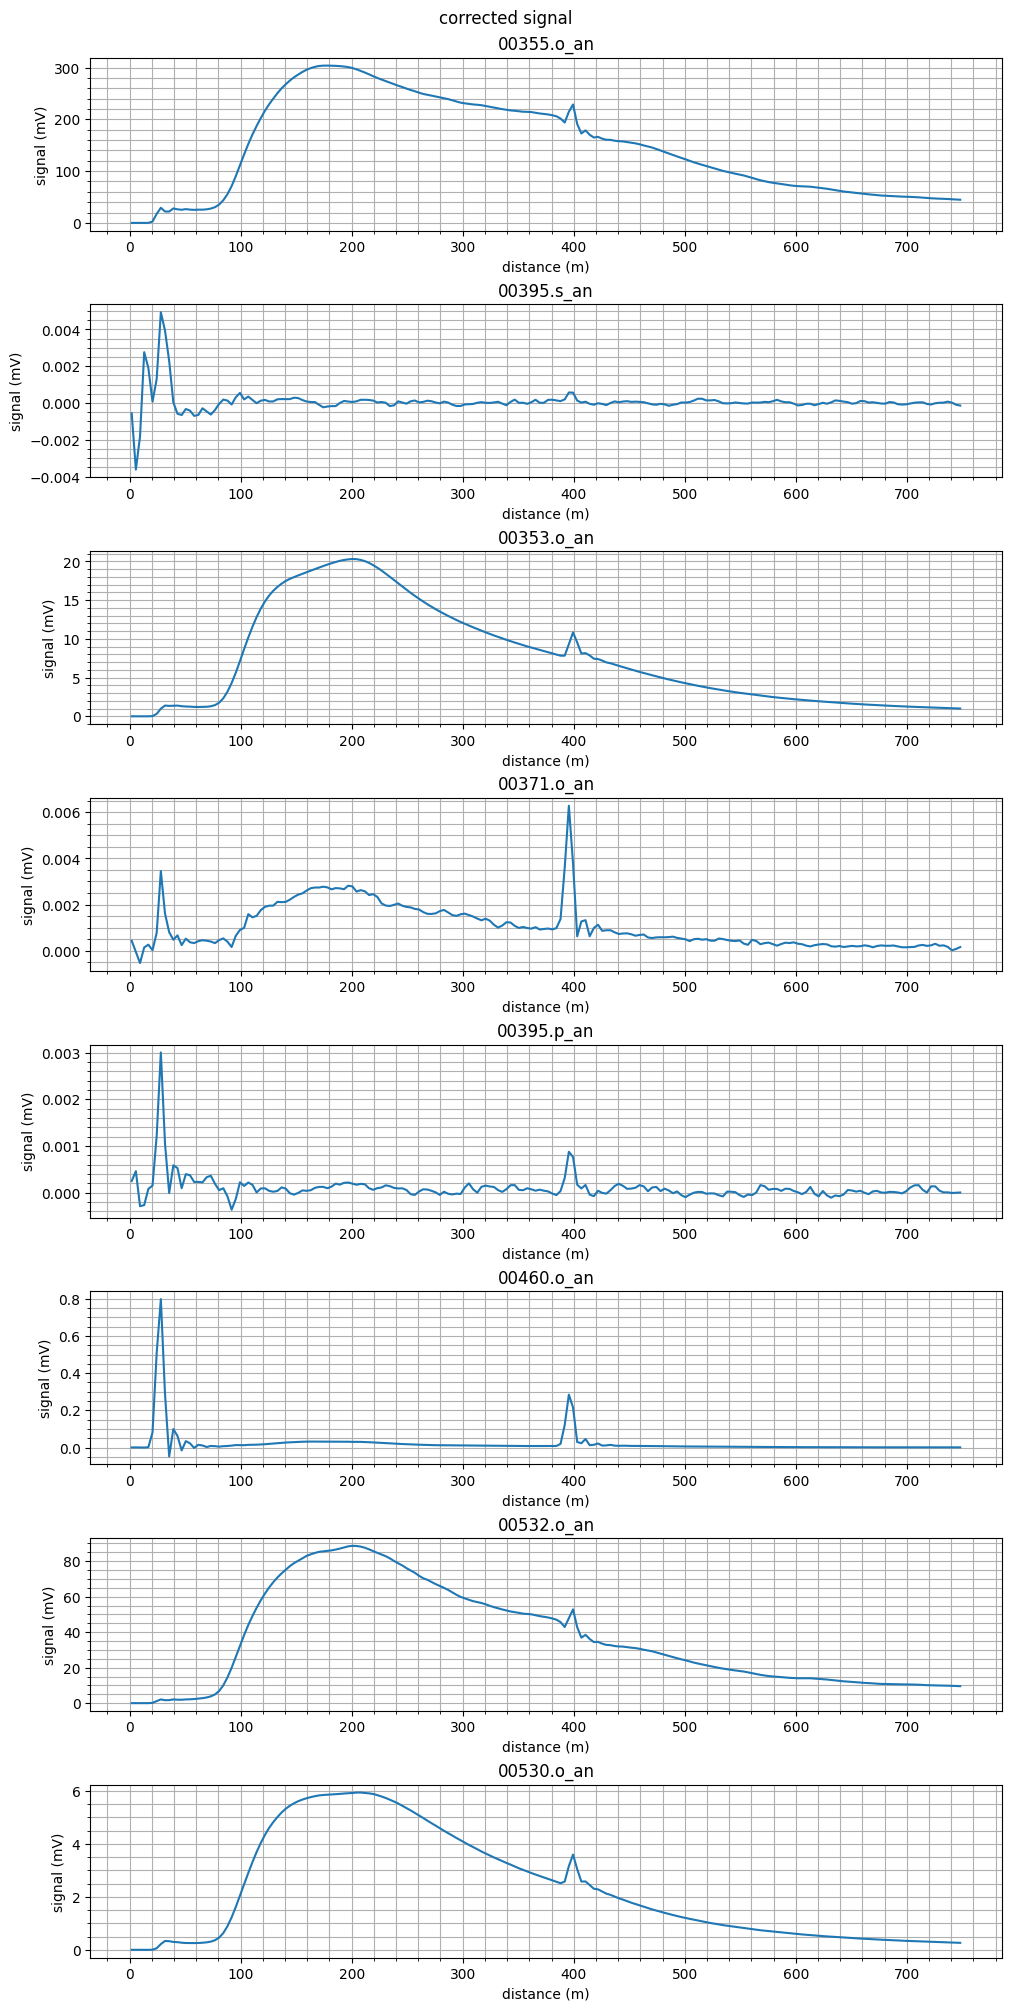

In [6]:
# Remove background
signal_corrected = signal - background

fig, ax = plt.subplots(nrows=len(signal_corrected), figsize=(10,20), layout='constrained')
fig.suptitle("corrected signal")
for i,trace in enumerate(signal_corrected):
    ax[i].plot(distance[:200], trace[:200])
    ax[i].set_title(licel_channels_names[i])
    ax[i].grid(True, 'both')
    ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    ax[i].set_ylabel('signal (mV)')

fig.savefig('signals_lidar.png')

In [7]:
# Constantes de calibracao
# CH4
ch4_cross_355 = 0   
ch4_395s = -1
ch4_395p = 0.5

# CO2
co2_cross_355 = 0
#co2_fluo_460 = -2.3e-3
co2_fluo_460 = -2.0e-3
co2_fluo_ch4 = 0
co2_371 = 1

# N2/O2
n2o2_cross_355 = 0 #-0.006
n2o2_cross_532 = 0
n2o2_353 = 1
n2o2_530 = 1

# Fluorescencia
fluo_460 = 1
fluo_ch4 = 1

calib = np.array([[ch4_cross_355, ch4_395s, 0, 0, ch4_395p, 0, 0, 0],
                  [co2_cross_355, 0, 0, co2_371, 0, co2_fluo_460, 0, 0],
                  [n2o2_cross_355, 0, n2o2_353, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, n2o2_cross_532, n2o2_530],
                  [0, 0, 0, 0, fluo_ch4, 0, 0, 0],
                  [0, 0, 0, 0, 0, fluo_460, 0, 0]])



# Remove background
signal_corrected = signal - background
# apply calibration
signal_calibrated = np.dot(calib, signal_corrected)


NameError: name 'titulo' is not defined

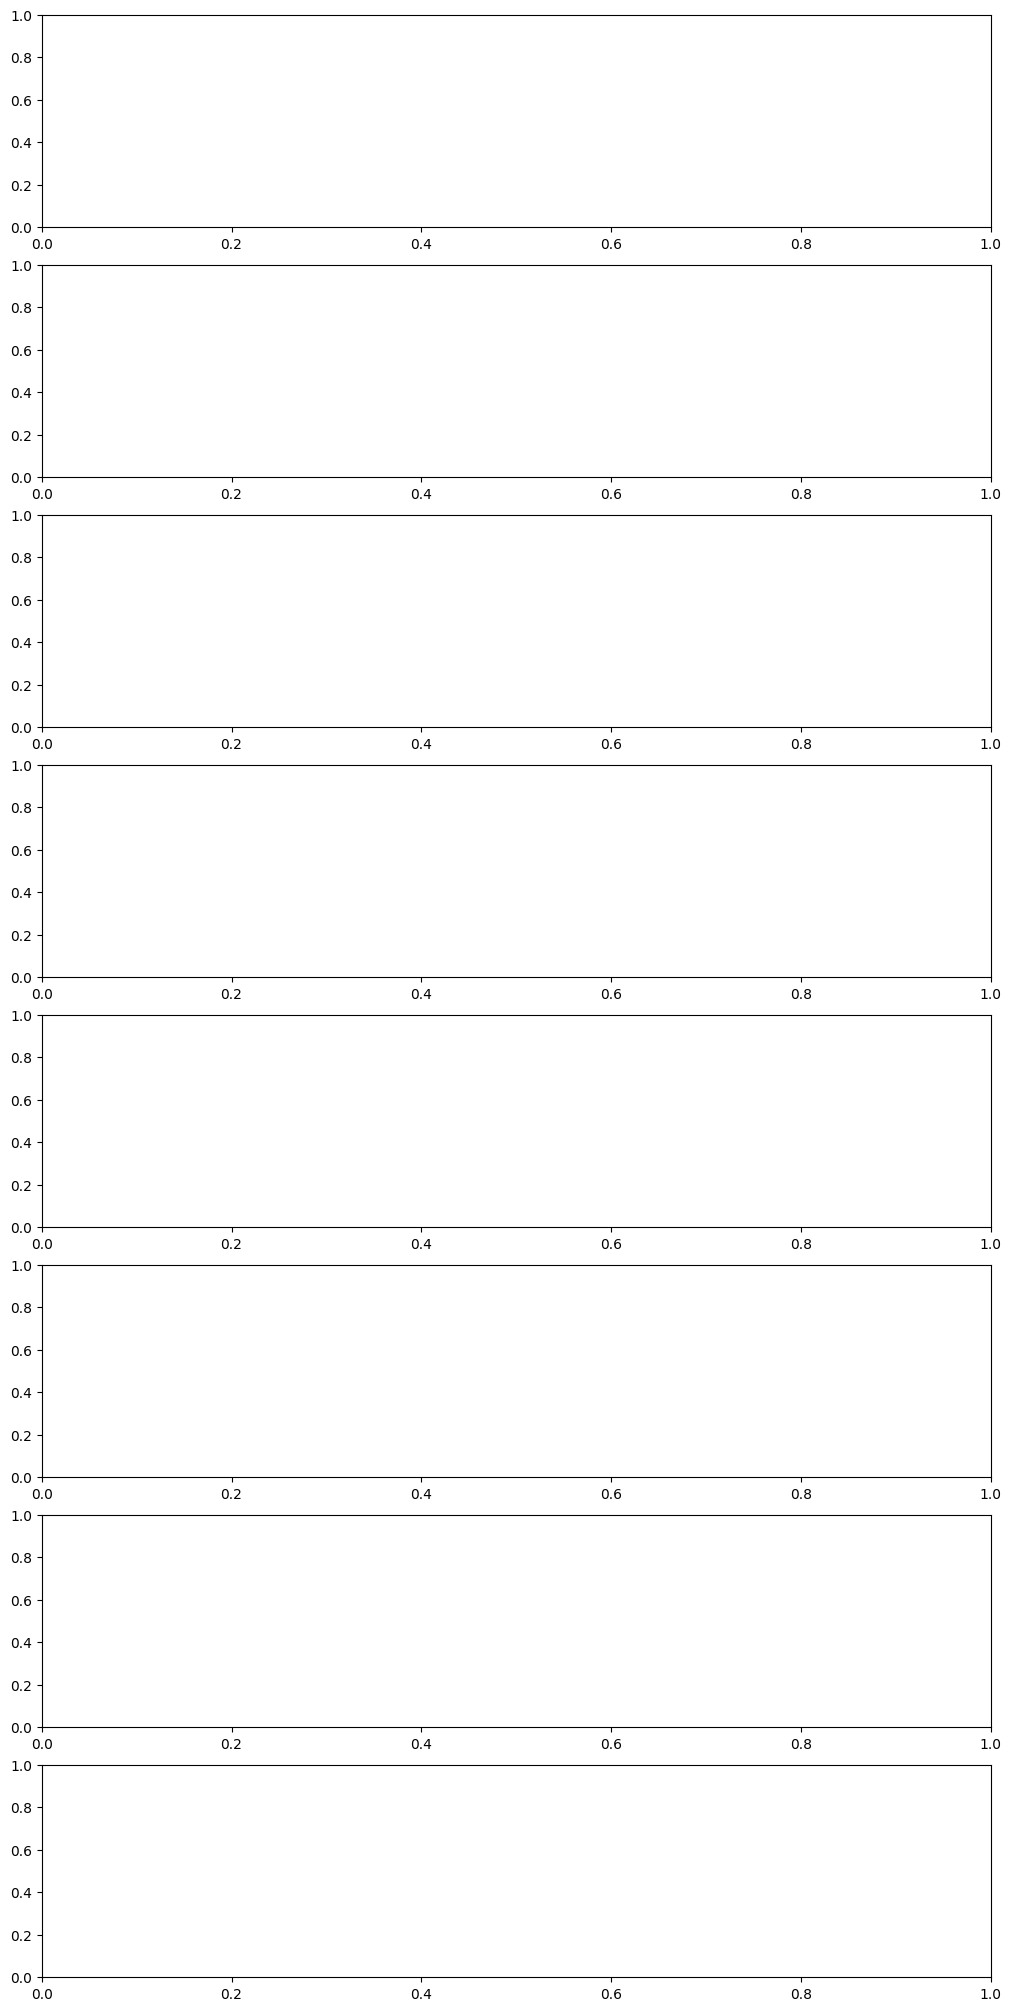

In [8]:
fig, ax = plt.subplots(nrows=len(signal_corrected), figsize=(10,20), layout='constrained')
fig.suptitle(titulo)
for i,trace in enumerate(signal_corrected):
    ax[i].plot(distance, trace)
    ax[i].set_title(licel_channels_names[i])
    ax[i].grid(True, 'both')
    ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    ax[i].set_ylabel('signal (mV)')

fig.savefig('signals_lidar.png')

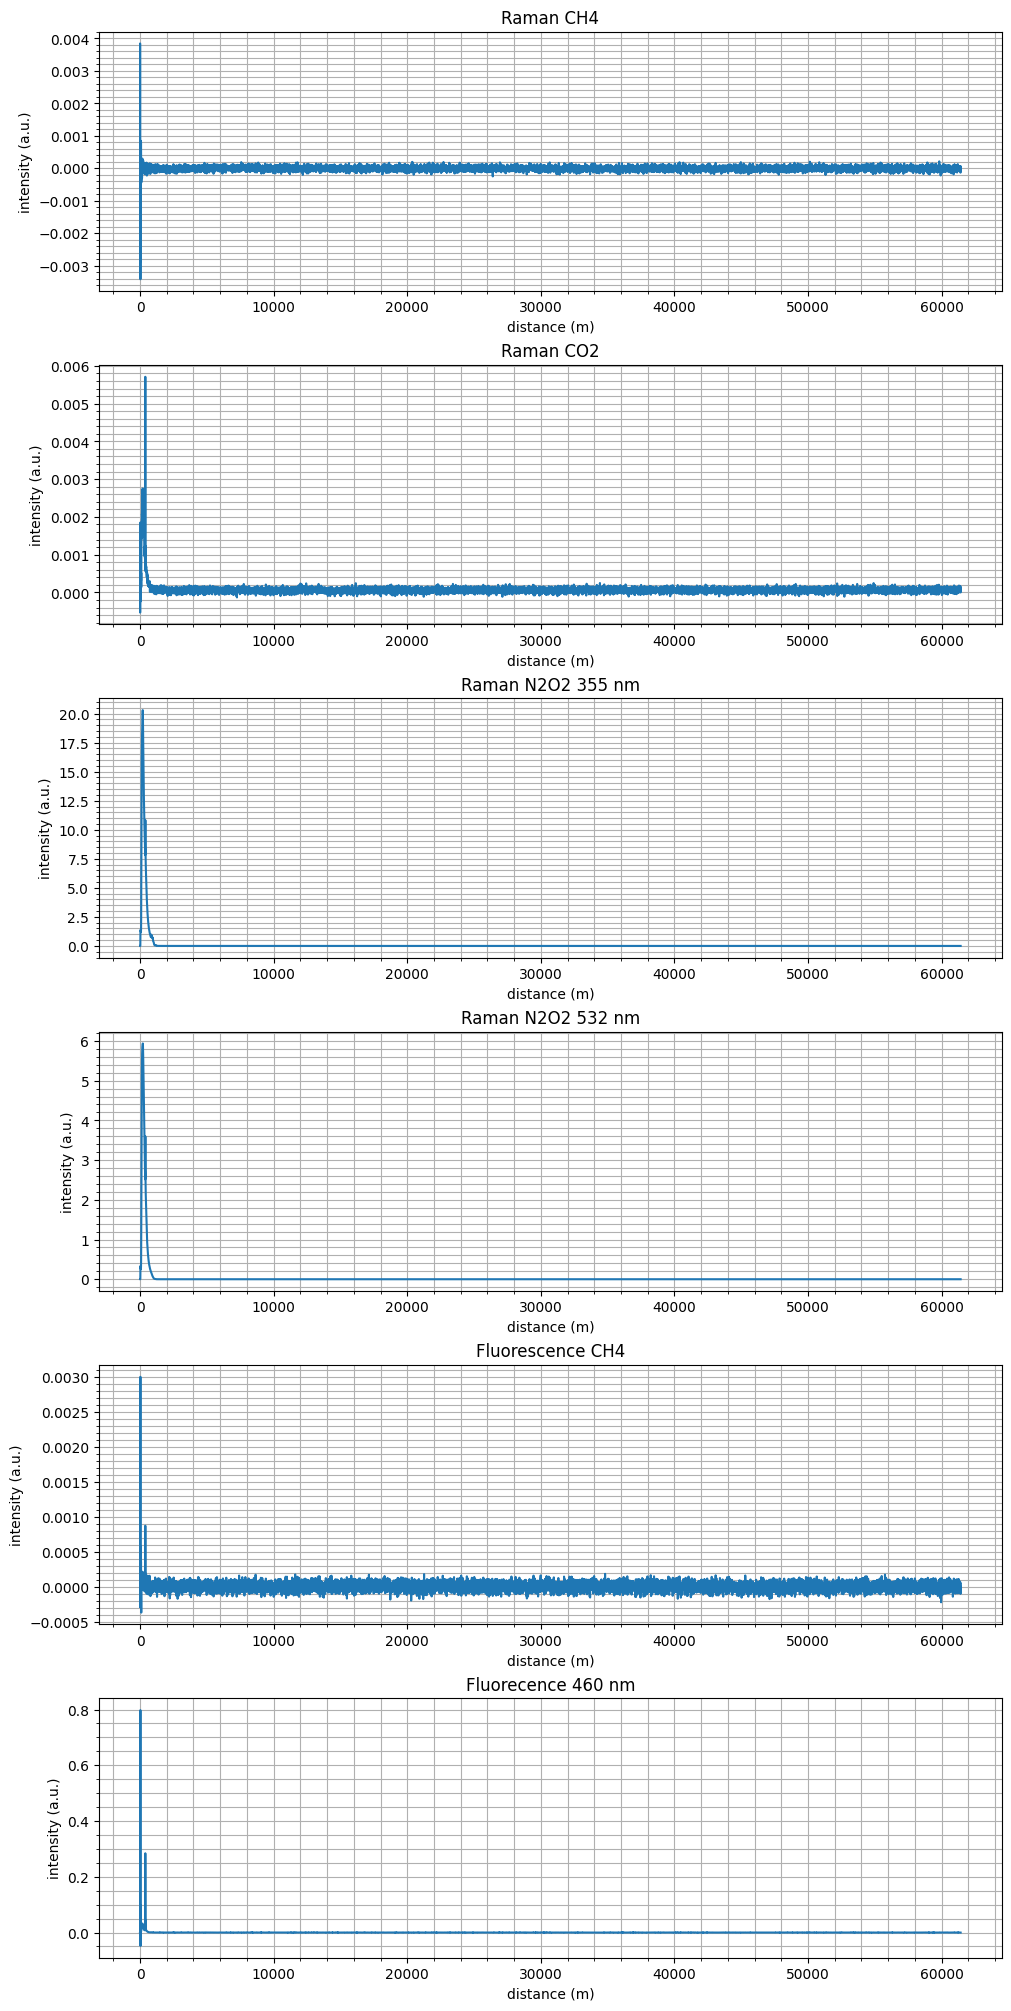

In [9]:
fig, ax = plt.subplots(nrows=len(signal_calibrated), figsize=(10,20), layout='constrained')
for i,trace in enumerate(signal_calibrated):
    ax[i].plot(distance, trace)
    ax[i].set_title(calibrated_channel_names[i])
    ax[i].grid(True, 'both')
    ax[i].minorticks_on()
    ax[i].set_xlabel('distance (m)')
    ax[i].set_ylabel('intensity (a.u.)')